# Описание проекта

Задача

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. 

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:

научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

проанализировать основные признаки, наиболее сильно влияющие на отток;

сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
- 1) выделить целевые группы клиентов;
- 2) предложить меры по снижению оттока;
- 3) определить другие особенности взаимодействия с клиентами.

## Шаг 1. Загрузка данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц: 
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.



Загрузим необходимые библиотеки и данные

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
print(df.shape)
df.head()

(4000, 14)


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В датасете 4000 строк по 14 признакам. Изучим их подробнее

## Шаг 2. Исследовательский анализ данных (EDA)

Изучим данные, посмотрим, есть ли пропуски, и какие вообще значения для разных столбцов

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


- Категориальные данные (такие, как пол, расположение в районе) уже приведены к числовым типам
- В столбцах нет явных пропусков
- Большая часть клиентов ходит в фитнес-клуб в своем районе (Near location, среднее ближе к 1)
- Большая часть клиентов имеет абонемент на месяц - это минимальное значение Contract peroid, абонементов на 6 месяцев и год меньше (среднее сильно отличается от медианы, которая равна единице)
- Больше половины клиентов не посещает групповые занятия (медиана равна 0)
- Клиенты имеют возраст от 18 до 41 года,  в среднем - 29 лет
- Столбец месяцев до конца абонемента (Month to end contract) явно связан со столбцом абонемента (Contract period), и, соотвественно, как и в том столбце медиана и среднее сильно различается: .
- В среднем клиенты посещают фитнес 3 месяца на момент наблюдения, хотя есть значения в 31 месяц
- Характеристики частоты посещения в текущем месяце (Avg_class_frequency_current_month) и вообще (Avg_class_frequency_total) - очень похожи - медианные и средние значения чуть меньше 2 раз в неделю
- Отток клиентов составляет 26.52% (поскольку в столбце только нули и единицы, то среднее по сути равно доле единиц)


Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.


In [4]:
df.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По средним значениям видно, что:
- среди "не оттекших" клиентов больше сотрудников компаний-партнеров (видимо, играет роль скидка);
- те, кто приходит с акции "приведи друга" чаще остаются, чем не остаются (с друзьями интересней)
- абонемент лояльных клиентов в среднем дольше (почти 6 месяцев вместо 1.7 для тех кто ушел)
- лояльные клиенты чаще посещают групповые занятия
- средний возраст лояльных клиентов выше на 3 года, т.е. чем старше человек, тем меньше вероятность оттока
- лояльные клиенты больше в среднем тратят на допуслуги
- лояльные клиенты в 2 раза чаще в среднем посещают зал

Теперь построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток), а также матрицу корреляций для признаков

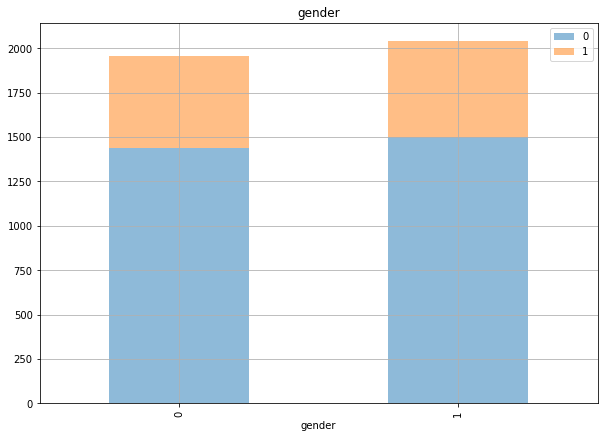

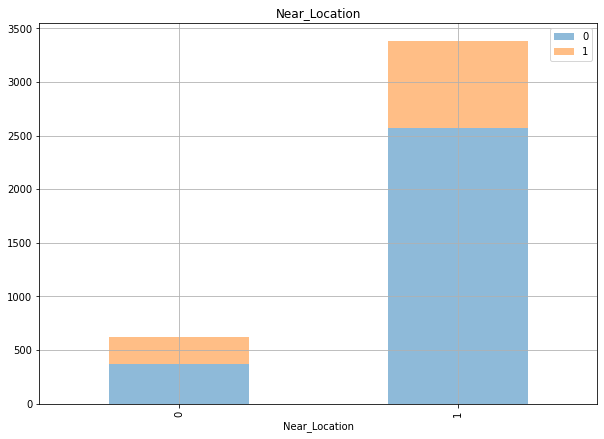

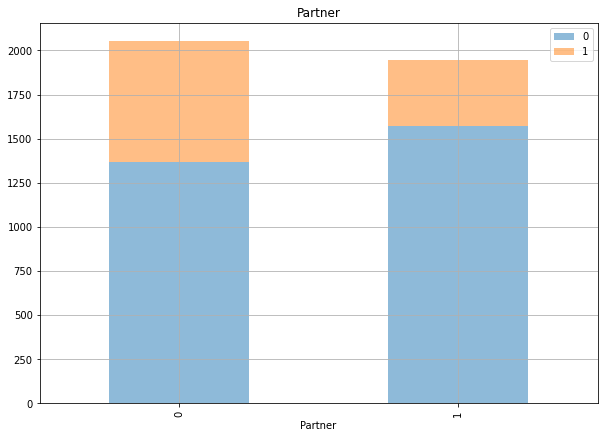

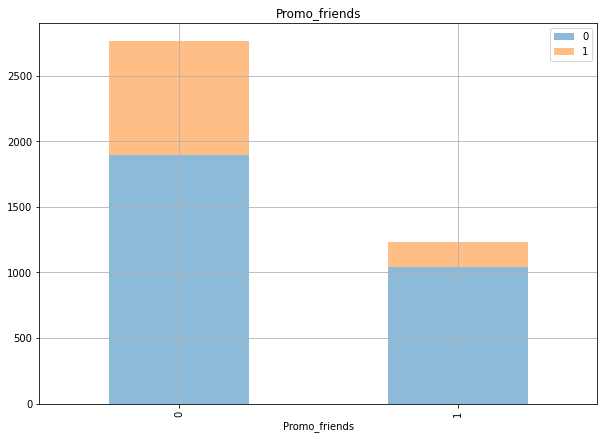

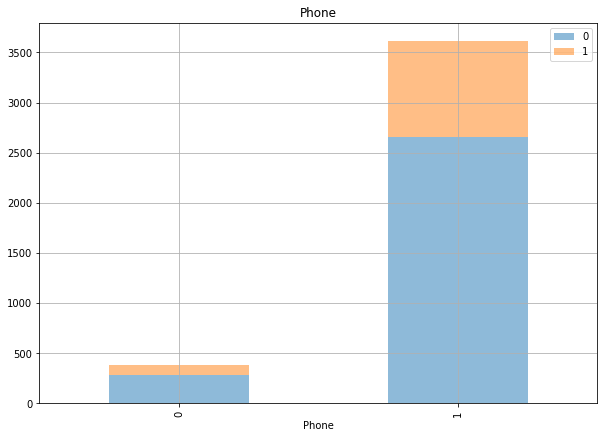

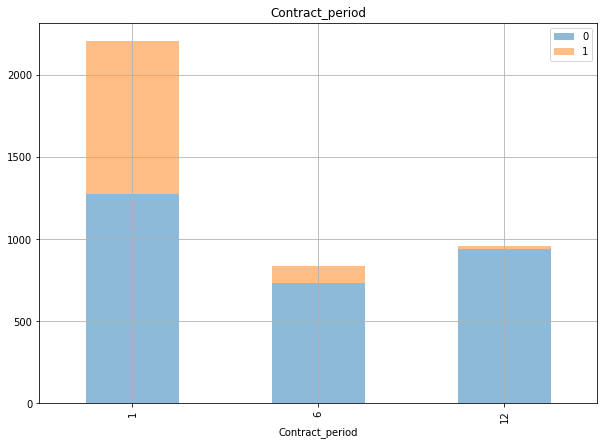

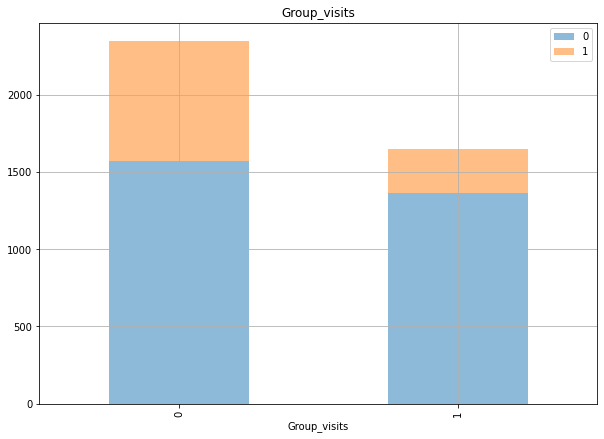

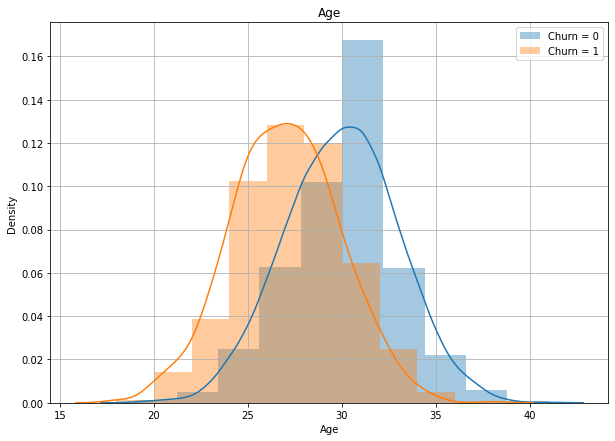

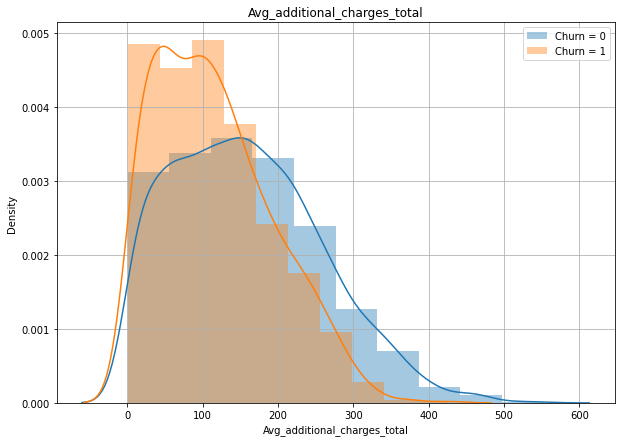

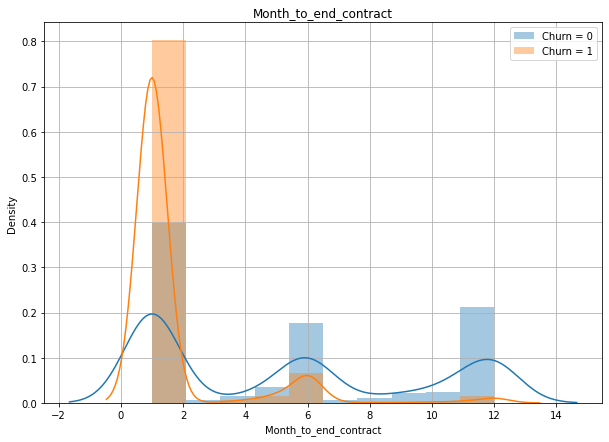

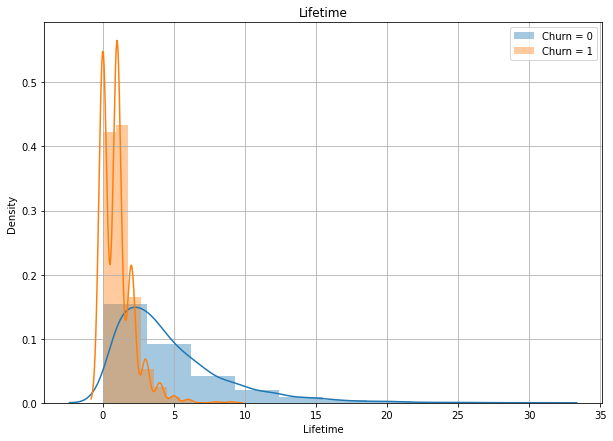

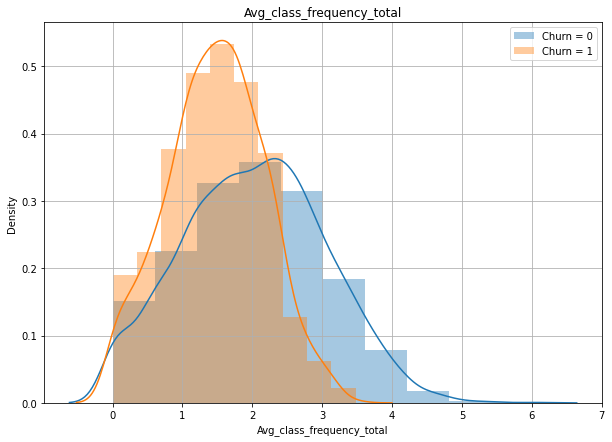

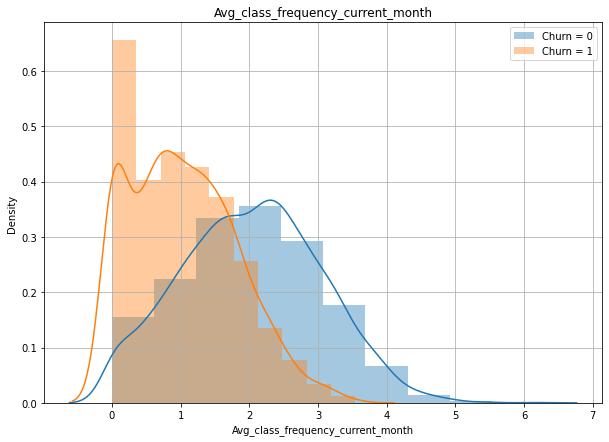

In [5]:
# напишем функцию, которая строила бы графики с группировкой по одному параметру и где можно было бы указывать
# данные (df), параметр группировки (group_col, в этом случае Churn), параметр по которому строятся графики (key_col)
def feat_hist(df, group_col, key_cols):
    df_new = df.copy()[key_cols]
    for c in key_cols:
        plt.rcParams["figure.figsize"] = (10,7)
        #plt.figure(figsize=(10,7))
 #отсекаем столбец, по которому группировка
        if c == group_col: continue
 #если у показателя немного значений (меньше 10), строим столбчатую диаграмму
        if len(df_new[c].unique()) < 10:
            report = df_new.reset_index().pivot_table(index=c, columns=group_col, values='index', aggfunc='count')
            report.plot(kind='bar', stacked=True, alpha=0.5, figsize=(10,7))
 #если значений больше 10 - строим диаграммы распределения
        else:
            for c1 in df[group_col].unique():
                sns.distplot(df_new[df_new[group_col] == c1][c],
                             label = '{} = {}'.format(group_col, str(c1)), bins=10)
        
        plt.title(c)
        plt.grid()
        plt.legend()
        plt.show()
 
feat_hist(df, 'Churn', df.columns)

Визуализация подтверждает в целом то же, что видно по средним:
- разница по полам небольшая и стабильная в обоих группах
- те, у кого фитнес около дома меньше "оттекают"
- также работают скидки от компаний-партнеров - доля ушедших клинетов среди тех, кто пришел таким образом меньше, чем среди тех, кто просто пришел
- более лояльны те, кто пришли по акциям "приведи друга". Видимо, вместе веселее
- среди людей с "коротким" абонементами на месяц больше доля ушедших. (попробовал - не понравилось - ушел)
- среди посетителей групповых занятий доля лояльных клиентов больше
- возрастные показатели для обеих групп стремятся к нормальному распределению, но лояльные клиенты в целом постарше
- лояльные клиенты больше тратят на доп услуги
- у лояльных клиентов - большие сроки до конца абонементов, хотя здесь в обоих группах есть явные пики около 1, 6, 12 месяцев - это четко коррелируется с имеющимися абонементами
- у большинства тех, кто "оттек" срок посещений - 1-2 месяца, у лояльных клиентов  - гораздо более равномерное распределение значений
- также у лояльных клиентов более равномерное распределение частоты посещений и в целом они чаще посещают зал
- график частоты посещений в текущем месяце в целом похож на общий график частоты посещений и обладает теми же особенностями (равномернее для лояльных клиентов и значения больше)

Построим матрицу корреляций признаков

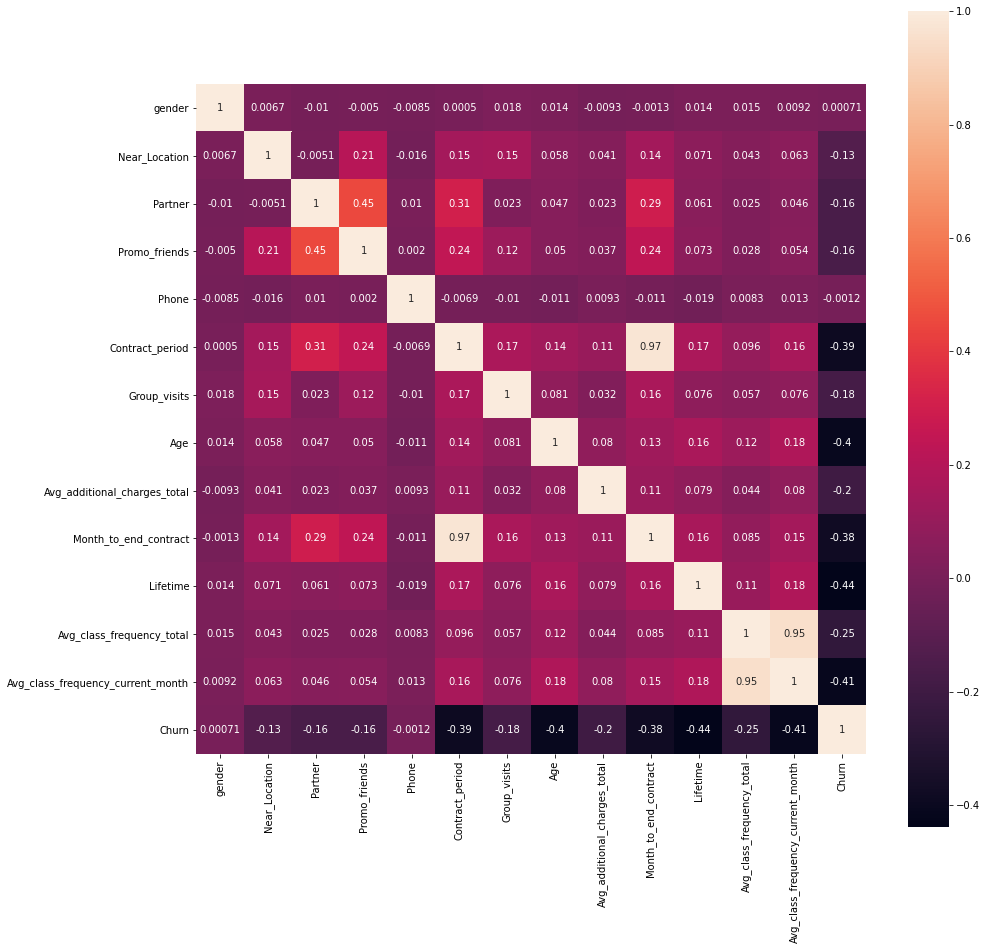

In [6]:
cm = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot = True, square = True)
plt.show()

По матрице корреляций видно, что средние количество посещений вообще и в месяц, а также время до конца абонемента и длительность абонемента - жестко мультиколлинеарны. Соответственно, по одному из этих признаков (Month_to_end_contract, Avg_class_frequency_current_month) можно удалить

In [7]:
df = df.drop(columns = ['Month_to_end_contract', 'Avg_class_frequency_current_month'])
#проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        4000 non-null   int64  
 1   Near_Location                 4000 non-null   int64  
 2   Partner                       4000 non-null   int64  
 3   Promo_friends                 4000 non-null   int64  
 4   Phone                         4000 non-null   int64  
 5   Contract_period               4000 non-null   int64  
 6   Group_visits                  4000 non-null   int64  
 7   Age                           4000 non-null   int64  
 8   Avg_additional_charges_total  4000 non-null   float64
 9   Lifetime                      4000 non-null   int64  
 10  Avg_class_frequency_total     4000 non-null   float64
 11  Churn                         4000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 375.1 KB


Данные изучены, подготовлены, можно приступить к построению модели

## Шаг 3. Модель прогнозирования оттока клиентов

Строим модели прогнозирования оттока клиентов

In [8]:
#делим данные на признаки (X) и целевую переменную (y)
X = df.drop(columns=['Churn'])
y = df['Churn']

#делим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#создаем объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)  

#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


#будем использовать две модели: логистическую регрессию и случайный лес
models = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators = 100, random_state = 0)]

#зададим функция, которая принимает на вход модель и данные и выводит метрики accuracy, precision и recall
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f} '
          .format(accuracy_score(y_test, y_pred),
                  precision_score(y_test, y_pred),
                  recall_score(y_test, y_pred)))
#применим
for i in models:
    print(i)
    make_prediction(m=i, X_train = X_train_st, y_train = y_train, X_test = X_test_st, y_test = y_test)

LogisticRegression(solver='liblinear')
Accuracy: 0.90 Precision: 0.79 Recall: 0.81 
RandomForestClassifier(random_state=0)
Accuracy: 0.89 Precision: 0.79 Recall: 0.76 


Cудя по результатам метрик, логистическая регрессия показала себя немного лучше, чем случайный лес - аккуратность и полнота для этой модели выше

## Шаг 4. Кластеризация клиентов

Теперь проведем кластеризацию клиентов. Для начала стандартизируем данные клиентов без оттока, т.е. нашу переменную X, построим матрицу расстояний и нарисуем дендрограмму

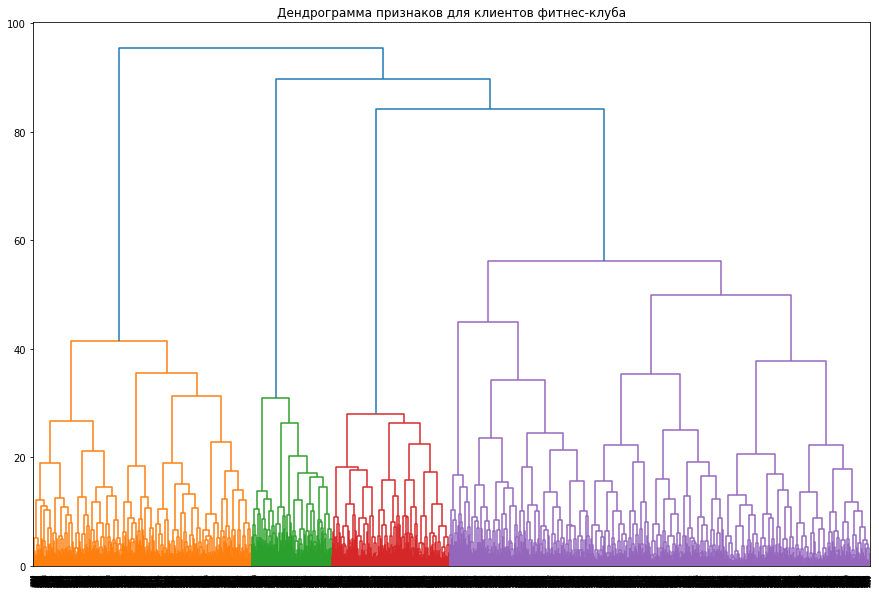

In [9]:
X_st = scaler.fit_transform(X)

#строим матрицу расстояний
linked = linkage(X_st, method = 'ward')
#рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма признаков для клиентов фитнес-клуба')
plt.show() 

Дендрограмма показывает, что оптимальное число кластеров - 5 (по числу цветов). Применим алгоритм K-Means

In [10]:
#зададим модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)
#прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_st)

#сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels
#проверим
df['cluster'].describe()

count    4000.000000
mean        1.867750
std         1.187482
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: cluster, dtype: float64

Посмотрим на средние значения для кластера и также построим диаграммы при помощи нашей функции feat_hist

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
cluster,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


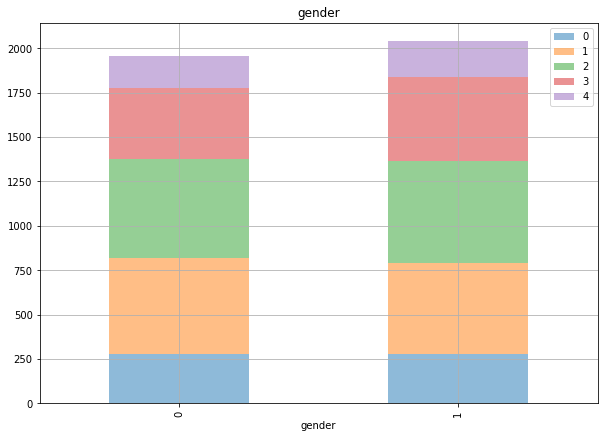

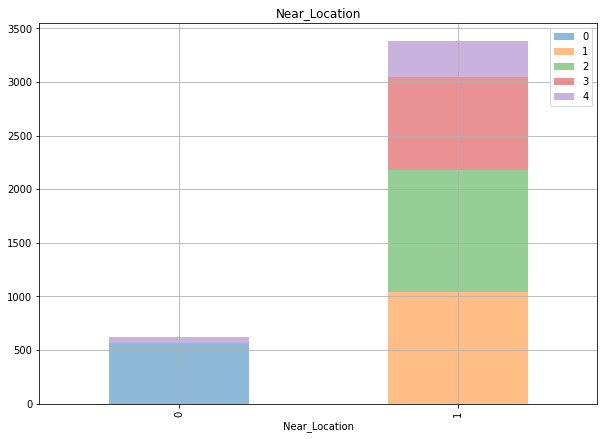

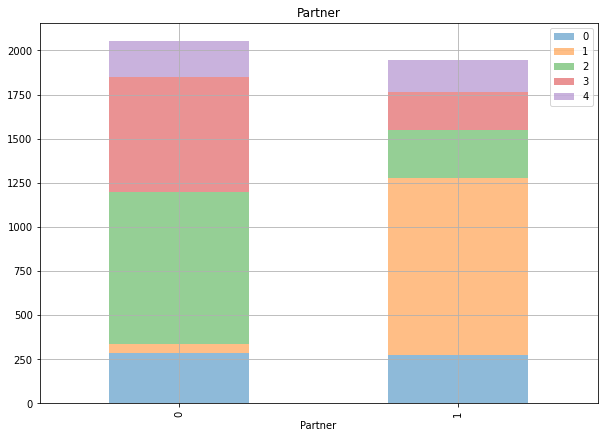

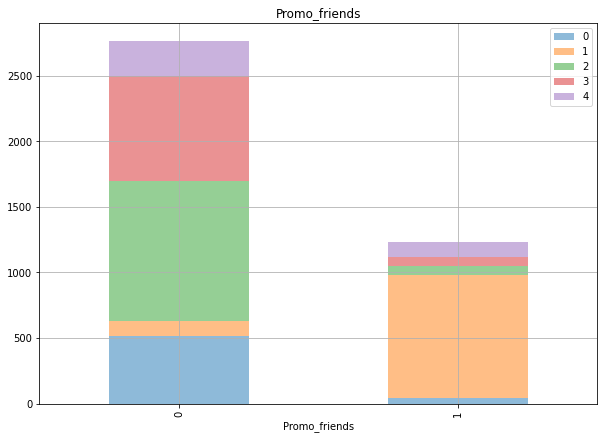

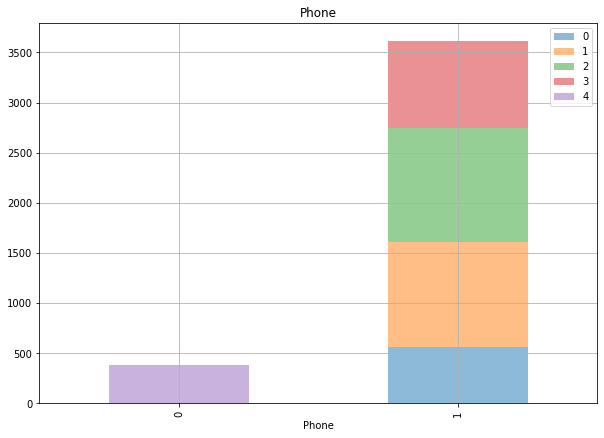

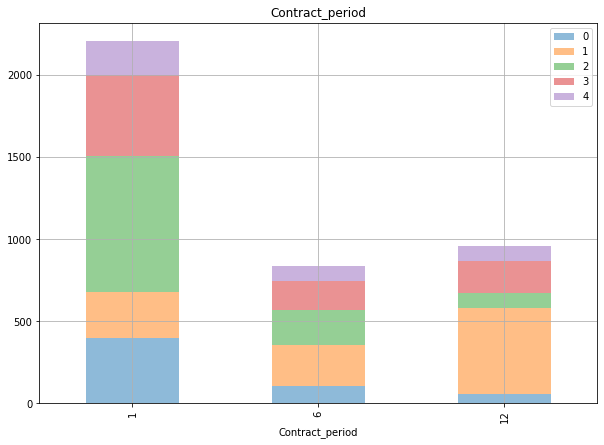

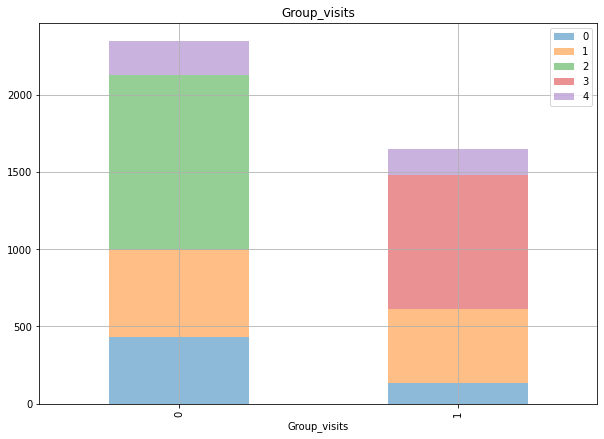

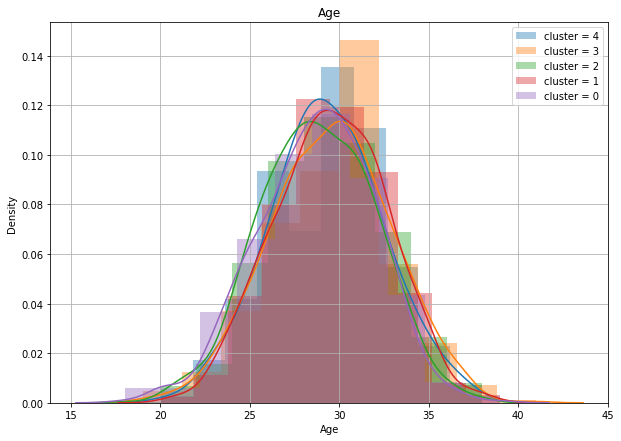

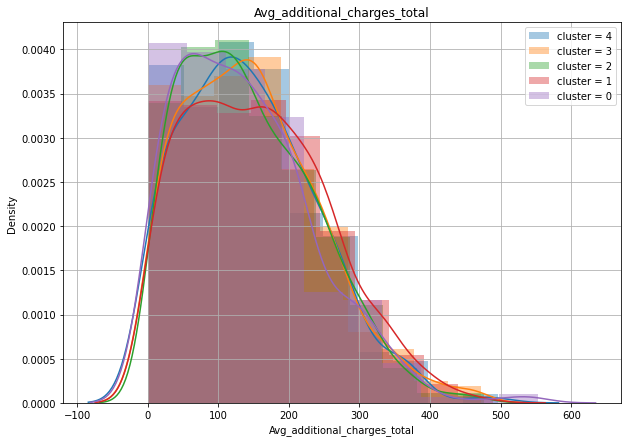

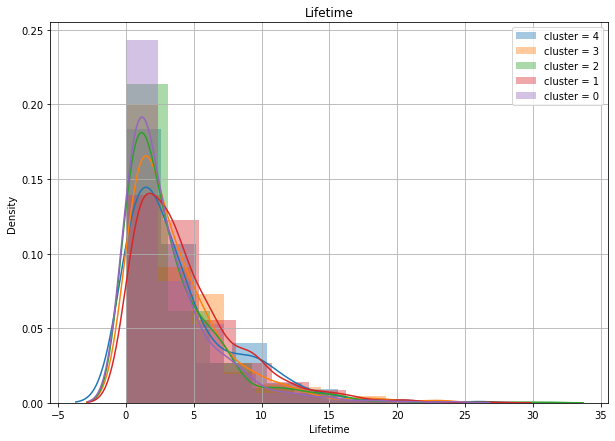

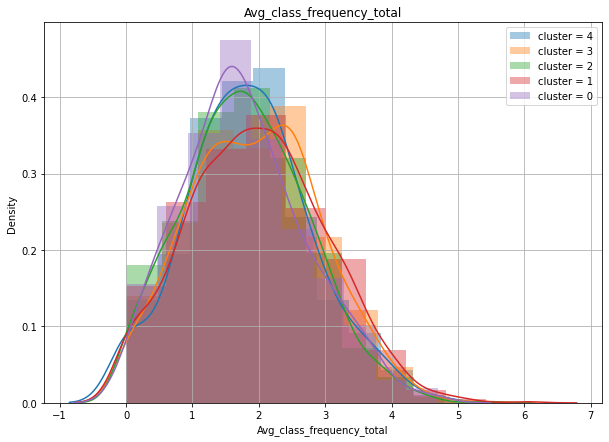

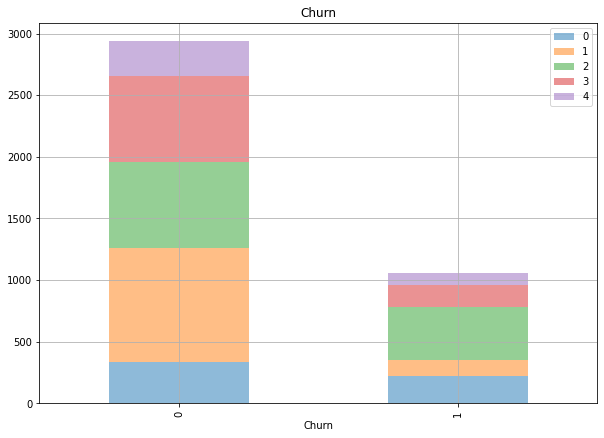

In [11]:
display(df.groupby('cluster').mean())
feat_hist(df, 'cluster', df.columns)

По средним значениям и визуализации для кластеров видно, что:
- в кластер 0 входят только те, от кого фитнес-центр находится далеко, в то время, как в кластеры 2 и 3 - только те, у кого центр рядом
- очень разная доля участников партнерских программ - меньше всего в кластерах 2 и 3. Видимо, они ходят преимущественно потому что фитнес рядом (см.предыдущий пункт), а не потому что скидка от работы
- в этиж же калстерах и кластере 0 - меньше всего процент по акции приведи друга
- в кластере 4 собрались все, кто не указал свой мобильный
- самый короткий средний абонемент (2.8 месяца) - в кластере 2, самый длинный (7.6) - в кластере 1
- в кластере 2 нет посетителей групповых занятий, а в кластере 3 их посещают все
- средний возраст, стоимость доп.услуг и среднее количество посещений по кластерам различаются не сильно
- по кластерам распределено время с момента первого посещения распределено в рамках 3 - 4.3 месяца
- в разных кластерах разная доля оттока: больше всего в кластере 0 (39.92%) и 2 (38.16%), меньше всего в кластере 1 - 12.09%

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами

Разные признаки по-разному влияют на вероятность оттока клиентов:
- расположение около дома или работы - очень важный признак, он значительно увеличивает вероятность того что клиент останется лояльным. Это значит, что фитнес-центры должны быть максимально территориально досутпными для новых пользователей (в случае, если есть возможность и задача расширения).
- промо-акции и партнерство с компаниями также в целом работают (это хорошо видно по кластеру 1, где процент таких людей очень высок и это самый "лояльный" калстер с большим отрывом). Но, надо отметить, что в исследовании не учитываются маркетинговые показатели таких акции
- чем больше человек вовлекается в жизнь фитнес-центра: начинает ходить на групповые занятия, чаще посещает зал - тем он лояльнее (самые "ненадежные" кластеры 0 и 2 - самые невовлеченные в групповые занятия. Возможно, нужны какие-то дополнительные меры, вовлекающие посетителей фитнес-центра в групповые программы и таким образом повышающие их лояльность.